In [1]:
import pandas as pd
import numpy as np
from scipy import stats
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.compose import TransformedTargetRegressor
from sklearn.linear_model import LinearRegression,LassoCV, RidgeCV, Lasso, Ridge
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.feature_selection import RFE
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import ElasticNet
import seaborn as sns
import matplotlib.pyplot as plt
import sys
if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")

In [2]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [3]:
X_val = pd.read_csv('../datasets/clean_filled/xval_clean.csv',keep_default_na=False,na_values='')
X_train = pd.read_csv('../datasets/clean_filled/xtrain_clean.csv',keep_default_na=False,na_values='')
df_test = pd.read_csv('../datasets/clean_filled/test_clean.csv',keep_default_na=False,na_values='')
y_val = pd.read_csv('../datasets/clean_filled/yval_clean.csv',keep_default_na=False,na_values='')
y_train = pd.read_csv('../datasets/clean_filled/ytrain_clean.csv',keep_default_na=False,na_values='')

In [4]:
X_val.shape,X_train.shape,df_test.shape

((506, 77), (1516, 77), (878, 77))

In [5]:
test_id = df_test['id']

#### Log Transforming y

Creating log transformations of the Sale Price data because of its skew. Will test during modeling whether it improves the accuracy of the model's predictions.

In [6]:
log_ytrain = np.log(y_train)

In [7]:
log_yval = np.log(y_val)

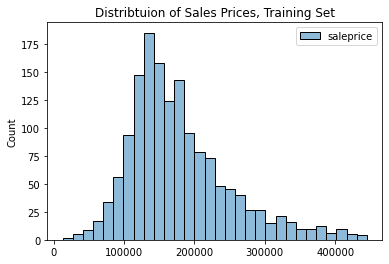

In [8]:
sns.histplot(y_train).set(title = 'Distribtuion of Sales Prices, Training Set');

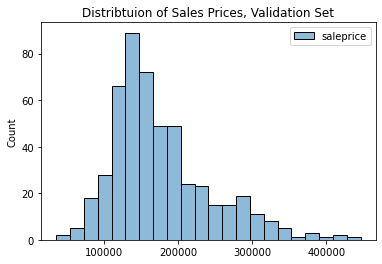

In [9]:
sns.histplot(y_val).set(title = 'Distribtuion of Sales Prices, Validation Set');

Below I take steps to split the data columns into the columns that will be treated as numerical and categorical when passed through the column transformer.

In [10]:
ordinal = ['overall_qual','overall_cond','exter_qual','exter_cond','bsmt_qual',\
    'bsmt_cond','bsmtfin_type_1','bsmtfin_type_2','heating_qc','electrical','kitchen_qual','functional',\
    'fireplace_qu','garage_finish','garage_qual','garage_cond','paved_drive','pool_qc','fence',\
    'lot_shape','utilities','land_slope','bsmt_exposure','area_qual']

In [11]:
num_as_cat = ['ms_subclass','bsmt_full_bath', 'bsmt_half_bath', 'full_bath', 'half_bath', 'bedroom_abvgr', 'kitchen_abvgr',\
             'garage_cars','mo_sold','yr_sold']

In [12]:
numeric = [col for col in X_train._get_numeric_data().columns if col not in ordinal and col not in num_as_cat]
categorical = [col for col in X_train.columns if col not in numeric]

### Preprocessing & Modeling

Below are the features that I dropped from my regression analysis.

The features I dropped to limit multicollinearity are below, identified through EDA:
* Garage cars, correlated to garage area.
* Garage condition, correlated to garage quality.
* Total rooms above ground/1st floor sq/2nd floor sq ..  correlated to above ground living area.
* Basement condition, correlated to basement quality.
* External quality, related to overall quality.
* Fireplace Quality, correlated to having a fireplace.

The remainder of the features were dropped through trial and error, finding what combination of features best explained the variance of sales price in the validation set of transactions. I took a very hands-on process in determining which features to include, and produced a model which generated results with an accuracy I was OK with, and with attention paid to the data science problem: what can our homeowners change in a matter of months. That being said, splitting data into what I deem can be changed/what cant be changed and then utilizing RFE would likely have contributed to the quicker identification of which features to include from a control standpoint, and which featurs to include from an inferential standpoint. However, when I arrived at a set of features that I felt answered my data science problem, with a model accuracy that I considered to be satisfactory, I elected not to proceed with utilizing further RFE.

In [13]:
extraneous = ['id','street','alley','lot_shape','bsmt_exposure','misc_val','misc_feature',\
             'pool_qc','bsmt_half_bath','bsmtfin_type_2',\
             'functional','low_qual_fin_sf','electrical',\
             'bsmtfin_sf_2','utilities',\
             'ms_zoning','mo_sold',\
             'enclosed_porch','kitchen_abvgr',\
             'heating','bsmt_unf_sf','bsmtfin_sf_1',\
             'roof_style','land_contour','ms_subclass', 'lot_frontage',
             'lot_config', 'land_slope', 'mas_vnr_type', 'mas_vnr_area',\
             'garage_type','exterior_2nd',\
             'area_qual','garage_finish','bsmtfin_type_1',\
             'yrs_sincerm','foundation',\
             'pool_area','roof_matl','exter_cond','3ssn_porch','screen_porch']             

multicoll = ['garage_cars','garage_cond','totrms_abvgrd','2nd_flr_sf','bsmt_cond', 'exter_qual','fireplace_qu',\
             '1st_flr_sf']


drops = extraneous + multicoll

Dropped same features for each set of observations.

In [14]:
Xtrain_d = X_train.drop(columns=drops)
Xval_d = X_val.drop(columns=drops)
dftest_d = df_test.drop(columns=drops)

The below are the features used for the regression modeling.

In [15]:
Xtrain_d.columns

Index(['lot_area', 'neighborhood', 'bldg_type', 'house_style', 'overall_qual',
       'overall_cond', 'exterior_1st', 'bsmt_qual', 'total_bsmt_sf',
       'heating_qc', 'central_air', 'gr_liv_area', 'bsmt_full_bath',
       'full_bath', 'half_bath', 'bedroom_abvgr', 'kitchen_qual', 'fireplaces',
       'garage_area', 'garage_qual', 'paved_drive', 'wood_deck_sf',
       'open_porch_sf', 'fence', 'yr_sold', 'sale_type', 'age'],
      dtype='object')

In [16]:
len(Xtrain_d.columns)

27

### Creating Null Baseline

Creating a null baseline to which we can compare the models we are building.

In [17]:
baseline_test = np.full_like(y_val,y_val.mean())
null_mse = mean_squared_error(y_val,baseline_test)
null_mae = mean_absolute_error(y_val,baseline_test)
null_rsme = np.sqrt(null_mse)
baseline_r2 = r2_score(y_val,baseline_test)
print('Baseline Test MSE is '+str(round(null_mse)))
print('Baseline Test RMSE is '+str(round(null_rsme)))
print('Baseline Test MAE is '+str(round(null_mae)))
print('Baseline R^2 is '+str(round(baseline_r2,4)))

Baseline Test MSE is 4417414053
Baseline Test RMSE is 66464
Baseline Test MAE is 51405
Baseline R^2 is -0.0


##  LR Analysis

The preprocessing done on the data was scaling of all numeric values, and One-hot-encoding of the categorical. The OHE dropped the first generated column of each feature to be used in comparative analysis. After this preprocessing was done in the pipeline, I began the regression analyses.

Below are the R-squared values I calculated for the permutations of regressions I ran, with the strongest regression last.

The first set was straighforward linear regression.. which resulted in strong r-squared values, but slight overfit:

* Train Set: 0.92974
* Validation Set: 0.90198
* K-Folds Cross Validation: 0.9131


When polynomial transformation was added to preprocessing pipeline, the model became very overfit, and variance was greatly increased.

* Train Set: 0.999
* Validaton Set: -2.6531
* K-Folds Cross Validation: -0.3231


The best model utilized just the linear regression, with a log transformation of the target. The values are strong, with a slight overfit. It does not seem excessive. The mean squared error is less than a tenth of the baseline figure.

* Train Set: 0.9333
* Validaton Set: 0.9140
* K-Folds Cross Validation: 0.9161


* Validation MSE: 379,836,316
* Baseline MSE: 4,417,414,053


I had also run an RFE regression with a linear regression estimator. As I previously stated, I had already manually approximated an RFE within the context of my data problem. Additionally, the RFE regression that resulted had worse metric results than the best lienar regression that I had run.

### LR Pipeline

In [18]:
ctx = ColumnTransformer(
    [('ss',StandardScaler(),[i for i in numeric if i not in drops]),
     ('ohe',OneHotEncoder(handle_unknown='ignore',drop='first'),\
     [i for i in categorical if i not in drops])],
     verbose_feature_names_out=False
)

lr_pipe = Pipeline(
    [
    ('ct',ctx),
    ('tt',TransformedTargetRegressor(regressor=LinearRegression(),func=np.log,inverse_func=np.exp))
    ]
)

lr_pipe_params = {
    'ct__remainder' : ['passthrough'],
    'ct__ss__with_mean' : [True, False],
    'ct__ohe__handle_unknown' : ['ignore'],
    'ct__ohe__sparse' : [False],
}

#### Fitting LR to Train

In [19]:
lr_pipe.fit(Xtrain_d,y_train)

Pipeline(steps=[('ct',
                 ColumnTransformer(transformers=[('ss', StandardScaler(),
                                                  ['lot_area', 'total_bsmt_sf',
                                                   'gr_liv_area', 'fireplaces',
                                                   'garage_area',
                                                   'wood_deck_sf',
                                                   'open_porch_sf', 'age']),
                                                 ('ohe',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'),
                                                  ['neighborhood', 'bldg_type',
                                                   'house_style',
                                                   'overall_qual',
                                                   'overall_cond',
                            

In [20]:
lr_pipe.score(Xtrain_d,y_train)

0.933335695270096

In [21]:
lr_pipe.score(Xval_d,y_val)

0.9140060849439802

In [22]:
cross_val_score(lr_pipe,Xtrain_d,y_train,scoring='r2',cv=5).mean()

0.9160654823553074

#### LR Predictions

In [23]:
t_preds = lr_pipe.predict(Xtrain_d)
mean_squared_error(y_train,t_preds)

347961042.9696282

In [24]:
v_preds = lr_pipe.predict(Xval_d)
mean_squared_error(y_val,v_preds)

379870728.792704

In [25]:
t_resids = y_train - t_preds
v_resids = y_val - v_preds

### Residual Analysis

When reviewing the log transformed residuals for the training set, they are fairly evenly distributed accross the set of predicted values. Residuals tend to grow a bit larger around the $300K salesprice mark. For both the training and validation sets, there is a house for which our model predicted a sale price of much higher than actual price.

#### TRAINING SET

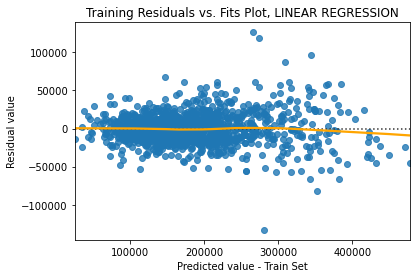

In [26]:
sns.residplot(x = t_preds,
              y = t_resids,
              lowess = True,
              line_kws = {'color':'orange'})\
    .set(title = 'Training Residuals vs. Fits Plot, LINEAR REGRESSION',
        xlabel = 'Predicted value - Train Set',
        ylabel = 'Residual value');

For the validation set, see that our predictions are fairly evenly distributed around 0 until the graph hits the $200K sale price mark. The model has an evident overfit element, when reviewed against the graph for the training set.

#### VAL SET

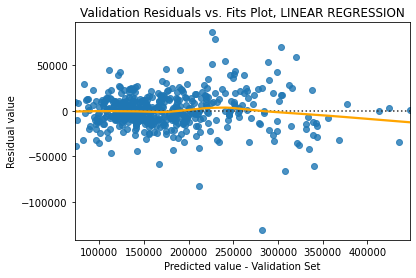

In [27]:
sns.residplot(x = v_preds,
              y = v_resids,
              lowess = True,
              line_kws = {'color':'orange'})\
    .set(title = 'Validation Residuals vs. Fits Plot, LINEAR REGRESSION',
        xlabel = 'Predicted value - Validation Set',
        ylabel = 'Residual value');

#### LR Scoring

Our model using Linear Regression and log transformed target explained 93.33% of variance of sale prices in the training set. This value fell to 91.4% for the validation set. The model is somewhat overfit, but not excessively so.

The K-fold cross validation score reaffirms this, caclulating am average r-squared of .9161 across five iterations.

####  LR Coefficients

Calculated the coefficients using a formula provided by the University of Virginia for converting target log transformed coefficients into percentages. This is the basis for which we will arrive at interpretable coefficients for all of our model that have log transformed targets moving forward.

https://data.library.virginia.edu/interpreting-log-transformations-in-a-linear-model/

In [28]:
lrcoefs = lr_pipe.named_steps['tt'].regressor_.coef_.tolist()
lrcl = [(np.exp(i) - 1)*100 for i in lrcoefs]

lrn = lr_pipe.named_steps['ct'].get_feature_names_out().tolist()
lrnl = [i for i in lrn]

lrcoef_zip = zip(lrnl,lrcl)
lrcoef_dict = {a:b for a,b in lrcoef_zip}

#lrcoef_dict

## Ridge Analysis

Below are the results from the RidgeCV regression analysis that was run, first with the default alphas, and then the final alpha number used, .2. Again, this data was scaled and one-hot-encoded.

Ridge with Default alphas:

* Train: 0.9291
* Validation: 0.9024
* K-Folds: 0.9136


Ridge with Default alphas and polynomial transformation. Again, model becomes much more overfit and has high variance.

* Train: 0.9875
* Validation: 0.8893
* K-Folds: 0.8899


Ridge with Default alphas and log transform target performs the best of the ridge regression run.

* Train: 0.9334
* Validation: 0.9147
* K-Folds: 0.9187

This is the best of the models run so far, with a lower MSE than the linear regression model. This is ultimately the model we proceed with for the final analysis presented.

* Ridge Validation MSE: 376,816,821
* LR Validation MSE: 379,870,534

    

#### Ridge Pipeline

In [29]:
ridge_pipe = Pipeline(
    [
    ('ct',ctx),
    ('ttr',TransformedTargetRegressor(regressor=RidgeCV(alphas=.20),func=np.log,inverse_func=np.exp))
    #('ridge',RidgeCV())
    ]
)

ridge_pipe_params = {
    'ct__remainder' : ['passthrough'],
    'ct__ss__with_mean' : [True, False],
    'ct__ohe__drop' : ['first'],
    'ct__ohe__handle_unknown' : ['ignore'],
    'ct__ohe__sparse' : [False],
}


#### Fitting Ridge to Train

In [30]:
ridge_pipe.fit(Xtrain_d,y_train)

Pipeline(steps=[('ct',
                 ColumnTransformer(transformers=[('ss', StandardScaler(),
                                                  ['lot_area', 'total_bsmt_sf',
                                                   'gr_liv_area', 'fireplaces',
                                                   'garage_area',
                                                   'wood_deck_sf',
                                                   'open_porch_sf', 'age']),
                                                 ('ohe',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'),
                                                  ['neighborhood', 'bldg_type',
                                                   'house_style',
                                                   'overall_qual',
                                                   'overall_cond',
                            

In [31]:
ridge_pipe.named_steps['ttr'].regressor_.alpha_

0.2

#### Ridge Predictions

Again, with a few exceptions, the errors are fairly well distributed around the mean.

In [32]:
rt_preds = ridge_pipe.predict(Xtrain_d)
mean_squared_error(y_train,rt_preds)

347268448.8074822

In [33]:
rv_preds = ridge_pipe.predict(Xval_d)
mean_squared_error(y_val,rv_preds)

376816821.16723657

In [34]:
ridt_resids = y_train - rt_preds
ridv_resids = y_val - rv_preds

#### TRAIN SET

The model does look similarly overfit, with residuals starting to grow when we approach the 300K in the training set and  200K in the validation. The apparent overfit in the model remains.

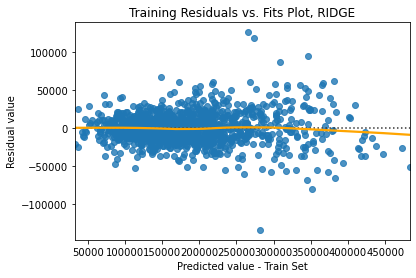

In [35]:
sns.residplot(x = rt_preds,
              y = ridt_resids,
              lowess = True,
              line_kws = {'color':'orange'})\
    .set(title = 'Training Residuals vs. Fits Plot, RIDGE',
        xlabel = 'Predicted value - Train Set',
        ylabel = 'Residual value');

##### VAL SET

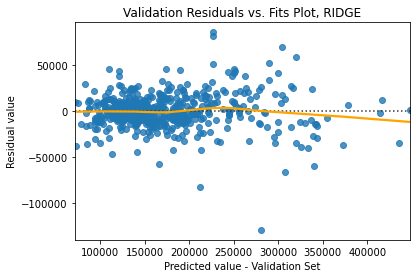

In [36]:
sns.residplot(x = rv_preds,
              y = ridv_resids,
              lowess = True,
              line_kws = {'color':'orange'})\
    .set(title = 'Validation Residuals vs. Fits Plot, RIDGE',
        xlabel = 'Predicted value - Validation Set',
        ylabel = 'Residual value');

#### Ridge Scoring

The Ridge regression providing the best regression used the alpha OF .2. and the log transformation of target. Using this model, we were able to explain 93.34% of the variation in the sale prices of the train set, 91.47% of the variation in the validation set, and this affirmed by a .9186 cross validation score, using 5 folds. This is the regression model that we will proceed with.

In [37]:
ridge_pipe.named_steps['ttr'].regressor_.alpha_

0.2

In [38]:
ridge_pipe.score(Xtrain_d,y_train)

0.9334683862974749

In [39]:
ridge_pipe.score(Xval_d,y_val)

0.9146974187400008

In [40]:
cross_val_score(ridge_pipe,Xtrain_d,y_train,scoring='r2').mean()

0.9186957994981346

#### Ridge Coefficients

The below ridge coefficients will be presented as final findings for this project.

In [41]:
ridgecoefs = ridge_pipe.named_steps['ttr'].regressor_.coef_.tolist()
ridgecl = [(np.exp(i) - 1)*100 for i in ridgecoefs]

ridgenames = ridge_pipe.named_steps['ct'].get_feature_names_out().tolist()
ridgenl = [i for i in ridgenames]

ridgecoef_zip = zip(ridgenl,ridgecl)
ridgecoef_dict = {a:b for a,b in ridgecoef_zip}
ridgecoef_dict

{'lot_area': 2.473853100479273,
 'total_bsmt_sf': 5.1939184236259095,
 'gr_liv_area': 12.341439632034179,
 'fireplaces': 1.2976103592820865,
 'garage_area': 1.6795957604840428,
 'wood_deck_sf': 1.028709551034357,
 'open_porch_sf': 0.6733211532110817,
 'age': -6.072447143629589,
 'neighborhood_Blueste': -1.4084011651593231,
 'neighborhood_BrDale': -7.98332698535984,
 'neighborhood_BrkSide': -4.932552398375112,
 'neighborhood_ClearCr': 0.3183537608993703,
 'neighborhood_CollgCr': -3.535941451843805,
 'neighborhood_Crawfor': 6.662196189105862,
 'neighborhood_Edwards': -8.707589022921224,
 'neighborhood_Gilbert': -4.828418028661718,
 'neighborhood_Greens': 2.4326858377296423,
 'neighborhood_GrnHill': 47.89051273597593,
 'neighborhood_IDOTRR': -12.891896150612524,
 'neighborhood_MeadowV': -18.697153303019544,
 'neighborhood_Mitchel': -3.3074832244532004,
 'neighborhood_NAmes': -3.3205114635674104,
 'neighborhood_NPkVill': -1.738313500747446,
 'neighborhood_NWAmes': -6.2905696445367365,
 'ne

### Ridge Gridsearch

The gridsearch of the Ridge regression (without CV) yielded a score of .9144 on the validation set, which is very close to the .9147 which was calculated with an alpha .2. The best score is .9177, which is veyr close to the .9187 cross val calculated above in the RidgeCV regression.

In [42]:
ridge_pipe2 = Pipeline(
    [
    ('ct',ctx),
    ('ttr',TransformedTargetRegressor(regressor=Ridge(),func=np.log,inverse_func=np.exp))
    ]
)


gsridge = GridSearchCV(
    ridge_pipe2,
    ridge_pipe_params,
    error_score = 'raise'
)


In [43]:
gsridge.fit(Xtrain_d,y_train)

GridSearchCV(error_score='raise',
             estimator=Pipeline(steps=[('ct',
                                        ColumnTransformer(transformers=[('ss',
                                                                         StandardScaler(),
                                                                         ['lot_area',
                                                                          'total_bsmt_sf',
                                                                          'gr_liv_area',
                                                                          'fireplaces',
                                                                          'garage_area',
                                                                          'wood_deck_sf',
                                                                          'open_porch_sf',
                                                                          'age']),
                                           

In [44]:
gsridge.score(Xtrain_d,y_train)

0.9321174559663098

In [45]:
gsridge.score(Xval_d,y_val)

0.9144120245234574

In [46]:
gsridge.best_score_

0.917741349140581

### LASSO Analysis

We continue on with our Lasso CV analysis below, again scaling and encoding the data.

Using default alphas for Lasso we generated similarly strong r-squared values, with more variation than we had seen prior, with lower validation score than train. K-folds is a bit higher than validation.

* Train: 0.9253
* Val: 0.8986
* K Folds: 0.9111


Using Lasso with log transform and a chosen range of alpha (.00001,0.1,.01), we were able to improve the training, validation, and K-folds scores, and reducte the variance.

* Train: 0.9335
* Validaton: 0.9142
* K-Folds: 0.9181


However, the previous Ridge regression slightly outperformed on Mean Sqaured Error:
* Ridge MSE: 378,077,525
* Lasso MSE: 378,903,832

#### Lasso Pipeline

In [47]:
lasso_pipe = Pipeline(
    [
    ('ct',ctx),
    ('ttl',TransformedTargetRegressor(regressor=LassoCV(alphas=np.arange(.00001,0.1,.001)),func=np.log,inverse_func=np.exp))
    ]
)

lasso_pipe_params = {
    'ct__ss__with_mean' : [True, False],
    'ct__ohe__drop' : ['first'],
    'ct__ohe__handle_unknown' : ['ignore'],
    'ct__ohe__sparse' : [False],
    'ttl__regressor__alphas' : [np.arange(.00001,0.1,.01)]
}



In [48]:
lasso_pipe.fit(Xtrain_d,y_train)

Pipeline(steps=[('ct',
                 ColumnTransformer(transformers=[('ss', StandardScaler(),
                                                  ['lot_area', 'total_bsmt_sf',
                                                   'gr_liv_area', 'fireplaces',
                                                   'garage_area',
                                                   'wood_deck_sf',
                                                   'open_porch_sf', 'age']),
                                                 ('ohe',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'),
                                                  ['neighborhood', 'bldg_type',
                                                   'house_style',
                                                   'overall_qual',
                                                   'overall_cond',
                            

#### Lasso Predictions

In [49]:
lassot_preds = lasso_pipe.predict(Xtrain_d)
lassot_preds = lassot_preds.reshape(1516,1)
mean_squared_error(y_train,lassot_preds)

347007846.4225074

In [50]:
lassov_preds = lasso_pipe.predict(Xval_d)
lassov_preds = lassov_preds.reshape(506,1)
mean_squared_error(y_val,lassov_preds)

378903832.05539674

In [51]:
lassot_resids = y_train - lassot_preds
lassov_resids = y_val - lassov_preds

The residuals follow a fairly similar distribution as those of the previous regression.

#### Training Set

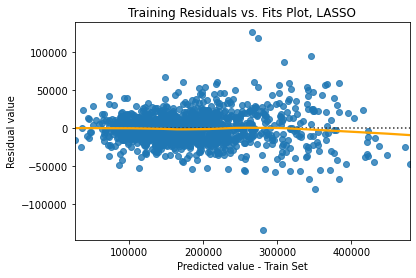

In [52]:
sns.residplot(x = lassot_preds,
              y = lassot_resids,
              lowess = True,
              line_kws = {'color':'orange'})\
    .set(title = 'Training Residuals vs. Fits Plot, LASSO',
        xlabel = 'Predicted value - Train Set',
        ylabel = 'Residual value');

#### VAL SET

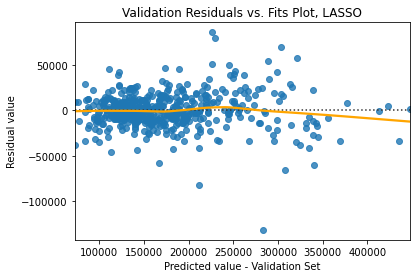

In [53]:
sns.residplot(x = lassov_preds,
              y = lassov_resids,
              lowess = True,
              line_kws = {'color':'orange'})\
    .set(title = 'Validation Residuals vs. Fits Plot, LASSO',
        xlabel = 'Predicted value - Validation Set',
        ylabel = 'Residual value');

#### Lasso Scoring

Through the target log transformed lasso model, we are able to explain .9292 of the variation 

In [54]:
lasso_pipe.score(Xtrain_d,y_train)

0.9335183139464354

In [55]:
lasso_pipe.score(Xval_d,y_val)

0.9142249679207238

In [56]:
cross_val_score(lasso_pipe,Xtrain_d,y_train,scoring='r2').mean()

0.9147468222466616

#### Lasso Coefficients

In [57]:
lassocoefs = lasso_pipe.named_steps['ttl'].regressor_.coef_.tolist()
lassocl = [(np.exp(i) - 1)*100 for i in lassocoefs]

lassonames = lasso_pipe.named_steps['ct'].get_feature_names_out().tolist()
lassonl = [i for i in lassonames]

lassocoef_zip = zip(lassonl,lassocl)
lassocoef_dict = {a:b for a,b in lassocoef_zip}
#lassocoef_dict


### GridSearch

In [58]:
lasso_pipe2 = Pipeline(
    [
    ('ct',ctx),
    ('ttl',TransformedTargetRegressor(regressor=Lasso(alpha=.0001),func=np.log,inverse_func=np.exp))
    ]
)

lasso_pipe_params2 = {
    'ct__ss__with_mean' : [True, False],
    'ct__ohe__drop' : ['first'],
    'ct__ohe__handle_unknown' : ['ignore'],
    'ct__ohe__sparse' : [False],
}

gslasso = GridSearchCV(
    lasso_pipe2,
    lasso_pipe_params2,
    cv =5,
    error_score = 'raise'
)


In [59]:
gslasso.fit(Xtrain_d,y_train)

GridSearchCV(cv=5, error_score='raise',
             estimator=Pipeline(steps=[('ct',
                                        ColumnTransformer(transformers=[('ss',
                                                                         StandardScaler(),
                                                                         ['lot_area',
                                                                          'total_bsmt_sf',
                                                                          'gr_liv_area',
                                                                          'fireplaces',
                                                                          'garage_area',
                                                                          'wood_deck_sf',
                                                                          'open_porch_sf',
                                                                          'age']),
                                     

In [60]:
gslasso.score(Xtrain_d,y_train)

0.933125712362749

In [61]:
gslasso.score(Xval_d,y_val)

0.913739478466191

In [62]:
gslasso.best_score_

0.9194251064697575

### Elastic Net Analysis

The elastic net analysis did not produce as strong a model as our previous iterations, even when utilizing the polynomial transformation.

#### Elastic Net Piepline

In [63]:
enet_pipe = Pipeline(
    [
    ('ct',ctx),
    ('poly',PolynomialFeatures()),
    ('enet',ElasticNet())
    ]
)

enet_pipe_params = {
    'ct__ss__with_mean' : [True, False],
    'ct__ohe__drop' : ['first'],
    'ct__ohe__handle_unknown' : ['ignore'],
    'ct__ohe__spares' : [False],
    'poly__degree' : [1,2],
    'poly__include_bias' : [False],
    'poly_interaction_only' : [True,False],
    'enet__alpha' : [np.logspace(0,5,100)],
    'enet__l1_ratio' : [.05]
}


In [64]:
enet_pipe.fit(Xtrain_d,y_train)

Pipeline(steps=[('ct',
                 ColumnTransformer(transformers=[('ss', StandardScaler(),
                                                  ['lot_area', 'total_bsmt_sf',
                                                   'gr_liv_area', 'fireplaces',
                                                   'garage_area',
                                                   'wood_deck_sf',
                                                   'open_porch_sf', 'age']),
                                                 ('ohe',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'),
                                                  ['neighborhood', 'bldg_type',
                                                   'house_style',
                                                   'overall_qual',
                                                   'overall_cond',
                            

#### Elastic Net Predictions

In [65]:
ent_preds = lasso_pipe.predict(Xtrain_d)
mean_squared_error(y_train,ent_preds)

347007846.4225074

In [66]:
env_preds = enet_pipe.predict(Xval_d)
mean_squared_error(y_val,env_preds)

428943765.9360249

### Elastic Net Scoring

In [67]:
enet_pipe.score(Xtrain_d,y_train)

0.9306417090326673

In [68]:
enet_pipe.score(Xval_d,y_val)

0.9028970884675854

In [69]:
cross_val_score(enet_pipe,Xtrain_d,y_train,scoring='r2').mean()

0.9029690468821865

#### Elastic Net Coefficients

In [70]:
enetcoefs = enet_pipe.named_steps['enet'].coef_.tolist()
encl = [i for i in enetcoefs]

enetnames = enet_pipe.named_steps['ct'].get_feature_names_out().tolist()
ennl = [i for i in enetnames]

enetcoef_zip = zip(ennl,encl)
enetcoef_dict = {a:b for a,b in enetcoef_zip}
#enetcoef_dictb

Ultimately it is the Ridge regression that will be chosen as the best predictor thas has been created.

### Production Ready

In [71]:
final_preds = ridge_pipe.predict(dftest_d)

In [72]:
final_preds = pd.DataFrame(final_preds,columns=['SalePrice'])

In [73]:
final_preds.shape

(878, 1)

In [74]:
final_preds.insert(loc=0,column='Id',value=test_id)

In [75]:
final_preds.head()

,Id,SalePrice
0,2658,100499.280395
1,2718,157286.943886
2,2414,208534.345341
3,1989,96568.006423
4,625,172018.678843


In [76]:
final_preds.shape

(878, 2)

In [77]:
final_preds.to_csv('../datasets/final_sub/submissiondscsv', index=False)

### Graphs

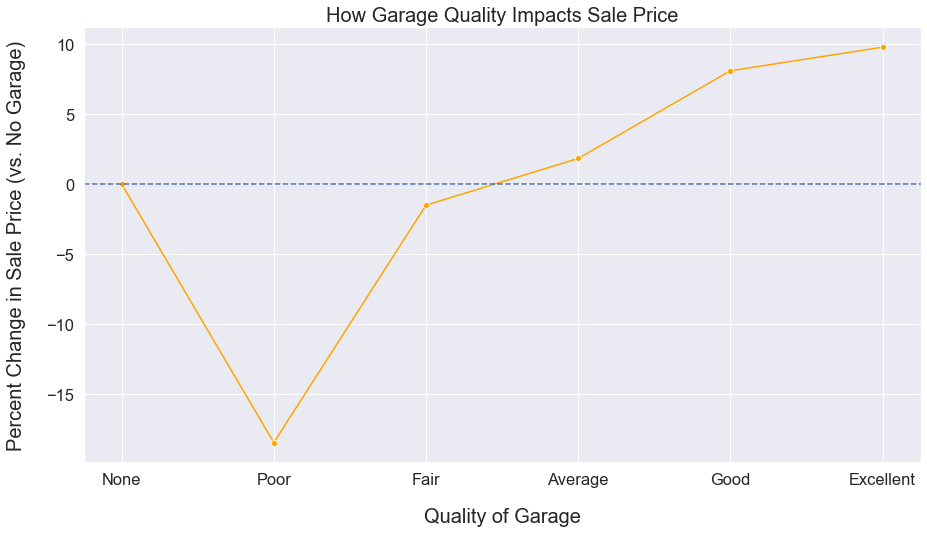

In [81]:
gq_coeffs = []
for k,v in ridgecoef_dict.items():
    if 'garage_qual' in k:
        gq_coeffs.append(v)
gq_coeffs.insert(0,0)
g_quals = ['None','Poor','Fair','Average','Good','Excellent']
sns.set(font_scale = 1.5)
plt.figure(figsize=(15,8))
sns.lineplot(x=g_quals,y=gq_coeffs,marker='o',color='orange').axhline(0,linestyle='--')
plt.ylabel('Percent Change in Sale Price (vs. No Garage)',fontsize=20,labelpad=20)
plt.xlabel('Quality of Garage',fontsize=20,labelpad=20)
plt.title('How Garage Quality Impacts Sale Price',fontsize=20)
plt.savefig('../images/garage.png');

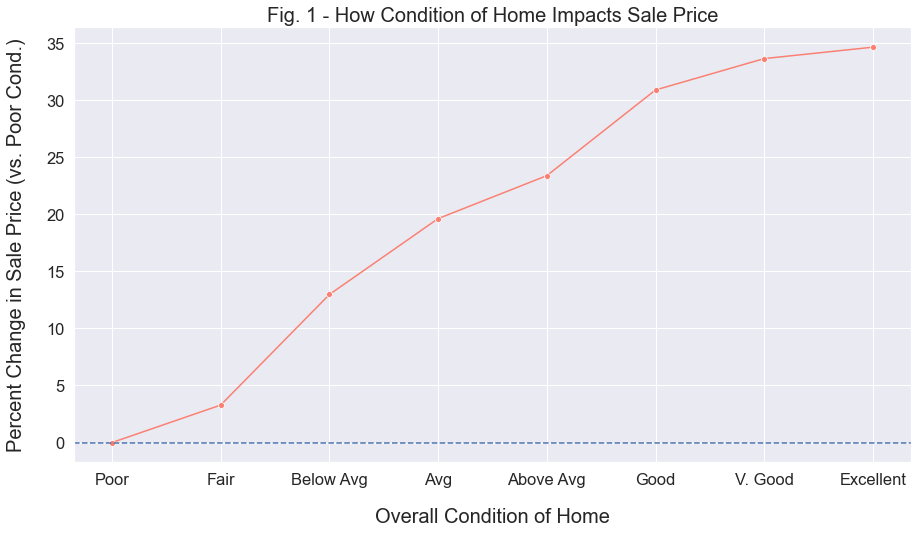

In [79]:
oc_coeffs = []
for k,v in ridgecoef_dict.items():
    if 'overall_cond' in k:
        oc_coeffs.append(v)
oc_coeffs[0] = 0
oc_coeffs
oc_conds = ['Poor','Fair','Below Avg','Avg','Above Avg','Good','V. Good','Excellent']
sns.set(font_scale = 1.5)
plt.figure(figsize=(15,8))
sns.lineplot(x=oc_conds,y=oc_coeffs,marker='o',color='salmon').axhline(0,linestyle='--')
plt.ylabel('Percent Change in Sale Price (vs. Poor Cond.)',fontsize=20,labelpad=20)
plt.xlabel('Overall Condition of Home',fontsize=20,labelpad=20)
plt.title('Fig. 1 - How Condition of Home Impacts Sale Price',fontsize=20)
plt.savefig('../images/overallcond.png');

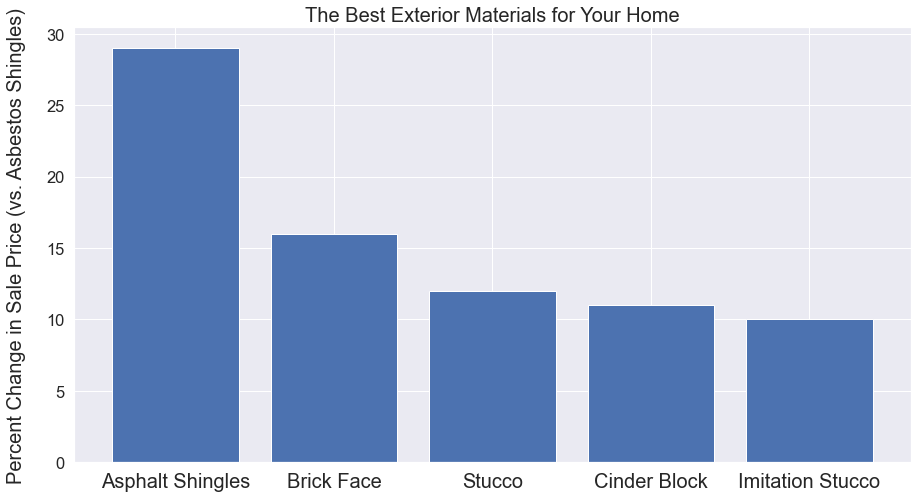

<Figure size 432x288 with 0 Axes>

In [82]:
plt.figure(figsize=(15,8))
exter_improv = [29, 16, 12, 11, 10]
material = ['Asphalt Shingles', 'Brick Face', 'Stucco', 'Cinder Block', 'Imitation Stucco']
y_pos = np.arange(len(exter_improv))
plt.bar(y_pos, exter_improv)
plt.xticks(y_pos, material,fontsize=20)
plt.ylabel('Percent Change in Sale Price (vs. Asbestos Shingles)',fontsize=20,labelpad=20)
plt.title('The Best Exterior Materials for Your Home',fontsize=20)
plt.show()
plt.savefig('../images/extmaterials.png');